# TCLab in the frequency domain

In [18]:
import numpy

In [19]:
%matplotlib inline

In [20]:
tau_p = 150
K_p = 0.33
theta = 15

In [21]:
omega = numpy.logspace(-3, -2)
s = omega*1j

In [22]:
G = K_p/(tau_p*s + 1)*numpy.exp(-theta*s)

In [23]:
import matplotlib.pyplot as plt

Let's choose 5 logarithmically spaced points around the corner frequency

In [24]:
freqs = numpy.logspace(-2.8, -2, 5)

In [25]:
def plotfreqs(ax):
    for freq in freqs:
        ax.axvline(freq)

In [26]:
def bode(omega, G, gainax=None, phaseax=None, phasecorr=0):
    if gainax is None:
        fig, (gainax, phaseax) = plt.subplots(2, 1, sharex=True)
    gainax.loglog(omega, numpy.abs(G))
    angle = numpy.angle(G)
    phaseax.semilogx(omega, numpy.unwrap(angle) + phasecorr)
    return gainax, phaseax

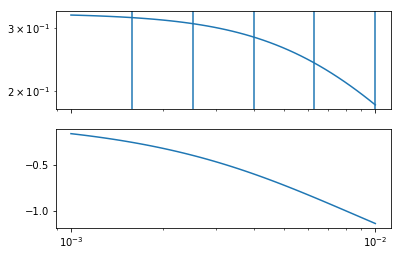

In [27]:
gainax, phaseax = bode(omega, G)
plotfreqs(gainax)

## Direct frequency domain tests

In [28]:
Qbar = 50
deltaQ = A = 10

How long does one sine wave take to repeat? 

$$P = 2\pi/\omega$$

In [29]:
P = 2*numpy.pi/freqs

We'll do a couple of repeats.

In [30]:
nperiods = 3

In [31]:
switch_times = numpy.concatenate([[0], numpy.cumsum(P*nperiods)])

In [32]:
switch_times

array([    0.        , 11893.26574888, 19397.409123  , 24132.20349893,
       27119.65678502, 29004.61237718])

In [33]:
from tclab import runexperiment, labtime

In [34]:
def send_sine_wave(t, lab):
    print(f'\rTime: {t} Last sleep: {labtime.lastsleep} ', end='')
    step = numpy.max(numpy.nonzero(switch_times <= t))
    lab.Q1(Qbar + A*numpy.sin(freqs[step]*(t - switch_times[step])))

In [35]:
totaltime = sum(nperiods*P)
totaltime

29004.612377178186

Experiment will take this many hours

In [36]:
totaltime/60/60

8.056836771438386

Looks like we'll be running it overnight.

In [57]:
%%time
experiment = runexperiment(send_sine_wave, connected=True, 
                           plot=False, twindow=1000,
                           time=int(totaltime), 
                           speedup=1,
                           dbfile='sinetest.db')

TCLab version 0.4.6dev
NHduino connected on port /dev/cu.wchusbserial1410 at 115200 baud.
TCLab Firmware 1.3.0 Arduino Uno.
Time: 4872.0 Last sleep: 0.8694100379943848 TCLab disconnected successfully.
CPU times: user 15.5 s, sys: 28 s, total: 43.6 s
Wall time: 1h 21min 16s


In [37]:
import tclab

In [38]:
h = tclab.Historian((('Q1', lambda: [0, 0, 0, 0]), 
                     ('Q2', None),
                     ('T1', None),
                     ('T2', None)), dbfile='sinetest.db')

In [39]:
# h = experiment.historian

In [40]:
h.get_sessions()

[(2, '2018-03-06 18:45:27', 13710),
 (12, '2018-03-07 14:55:43', 2001),
 (15, '2018-03-07 18:43:39', 7526),
 (25, '2018-03-08 05:34:09', 5523),
 (27, '2018-03-08 07:10:23', 4873),
 (28, '2018-03-08 12:59:29', 55),
 (29, '2018-03-08 13:00:31', 116),
 (30, '2018-03-08 13:02:35', 1001),
 (31, '2018-03-08 13:25:17', 2001),
 (32, '2018-03-08 14:30:19', 0),
 (33, '2018-03-08 14:30:32', 891),
 (34, '2018-03-08 14:46:08', 536),
 (35, '2018-03-08 14:55:18', 132),
 (36, '2018-03-08 15:02:28', 2001),
 (37, '2018-03-09 04:37:56', 0),
 (38, '2018-03-09 04:39:17', 0),
 (39, '2018-03-09 04:45:49', 0),
 (40, '2018-03-09 04:46:44', 0),
 (41, '2018-03-09 08:22:48', 0),
 (42, '2018-03-09 08:23:20', 0)]

In [41]:
import pandas

In [42]:
%matplotlib inline

In [43]:
# h = experiment.historian

In [44]:
sine_sessions = [2, 15, 25, 27]

In [45]:
def sinefit(session, freq, Tbar=40, inphase=0, gain=0.4, phase=0):
    h.load_session(session)
    t = numpy.array(h.t)
    Q1 = numpy.array(h.logdict['Q1'])
    Q1_sine = A*numpy.sin(t*freq + inphase)
    T1 = numpy.array(h.logdict['T1'])
    T1_sine = A*gain*numpy.sin(t*freq + inphase + phase)
    plt.plot(t, Q1 - Qbar, color='blue', alpha=0.4)
    plt.plot(t, Q1_sine, color='blue')
    plt.plot(t, T1 - Tbar, color='red', alpha=0.4)
    plt.plot(t, T1_sine, color='red')
    plt.ylim(-A, A)
    print(f'Gain={gain}, Phase={phase-inphase}')

Gain=0.3, Phase=0


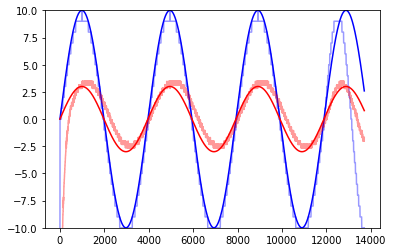

In [46]:
sinefit(2, freqs[0], 40, 0, 0.3, 0, )

In [47]:
from ipywidgets import interact

In [48]:
interact(sinefit, 
         session=sine_sessions, 
         freq=freqs, 
         Tbar=(30., 50.), 
         inphase=(0, 2*numpy.pi),
         gain=(0., 1., 0.01),
         phase=(-2*numpy.pi, 0),)

interactive(children=(Dropdown(description='session', options=(2, 15, 25, 27), value=2), Dropdown(description='freq', options=(0.001584893192461114, 0.002511886431509582, 0.003981071705534973, 0.00630957344480193, 0.01), value=0.001584893192461114), FloatSlider(value=40.0, description='Tbar', max=50.0, min=30.0), FloatSlider(value=0.0, description='inphase', max=6.283185307179586), FloatSlider(value=0.4, description='gain', max=1.0, step=0.01), FloatSlider(value=0.0, description='phase', max=0.0, min=-6.283185307179586), Output()), _dom_classes=('widget-interact',))

<function __main__.sinefit>

In [124]:
gains = [0.3, 0.32, 0.25, 0.24, 0.19]
phases = [-0.28, -0.38, -0.58, -0.88, -1.28]

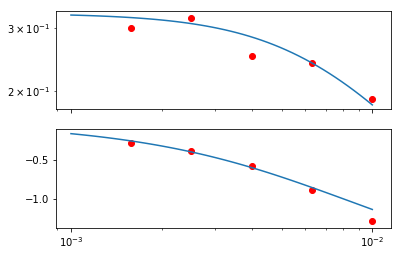

In [158]:
gainax, phaseax = bode(omega, G)
gainax.scatter(freqs, gains, color='red')
phaseax.scatter(freqs, phases, color='red')

## FFT based bode diagram

In [174]:
next_values = {'time': 0, 'value': +A}
def random_noise(t, lab):
    if t > next_values['time']:
        next_values['time'] += numpy.random.uniform(50, 300)
        next_values['value'] = -A if next_values['value'] == +A else +A
    lab.Q1(Qbar + next_values['value'])

In [175]:
next_values

{'time': 0, 'value': 10}

In [176]:
%matplotlib notebook

TCLab version 0.4.6dev
NHduino connected on port /dev/cu.wchusbserial1410 at 115200 baud.
TCLab Firmware 1.3.0 Arduino Uno.


<IPython.core.display.Javascript object>


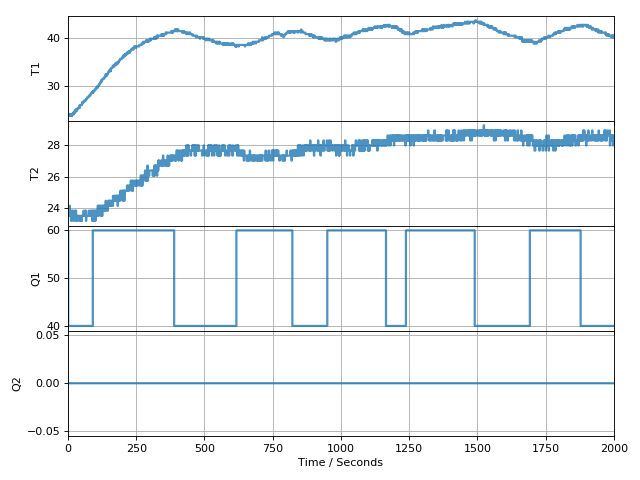

TCLab disconnected successfully.
CPU times: user 2min 30s, sys: 16.4 s, total: 2min 47s
Wall time: 33min 24s


In [177]:
%%time
experiment = runexperiment(random_noise, connected=True, 
                           plot=True, twindow=2000,
                           time=2000, 
                           speedup=1,
                           dbfile='sinetest.db',
                          )

In [181]:
h = experiment.historian

In [30]:
h.load_session(36)

In [31]:
%matplotlib inline

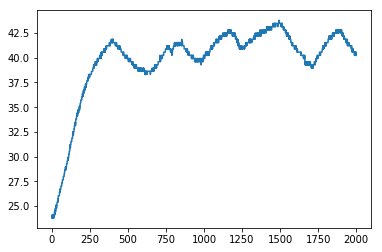

In [32]:
plt.plot(h.t, h.logdict['T1'])

In [33]:
import numpy

In [72]:
startcut = 900

In [73]:
Q1 = numpy.array(h.logdict['Q1'][startcut:])
T1 = numpy.array(h.logdict['T1'][startcut:])

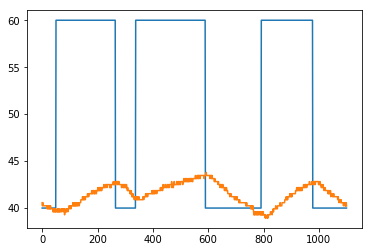

In [74]:
plt.plot(Q1)
plt.plot(T1)

In [75]:
u = numpy.fft.rfft(Q1 - Qbar)
y = numpy.fft.rfft(T1 - numpy.mean(T1))

In [76]:
omegafft = numpy.fft.rfftfreq(len(Q1), 1)
Gfft = y/u

(-1.5707963267948966, 0)

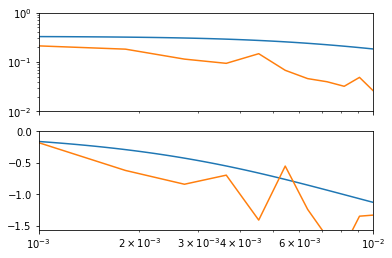

In [160]:
ga, pa = bode(omega, G)
bode(omegafft, Gfft, ga, pa, numpy.pi/4)
plt.xlim(1e-3, 1e-2)
ga.set_ylim(0.01, 1)
pa.set_ylim(-numpy.pi/2, 0)